### 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier 

### 2. Impoorting Dataset and Data Analysis

In [2]:
train_data = pd.read_csv(r'C:\Users\HELLO\Favorites\Downloads\Credit Card\train_s3TEQDk.csv', header=0)
test_data = pd.read_csv(r'C:\Users\HELLO\Favorites\Downloads\Credit Card\test_mSzZ8RL.csv', header=0)

In [3]:
# Understanding the dataset
# Shape of the training & testing data
print(train_data.shape)
print(test_data.shape)
print(train_data.describe())
print(test_data.describe())

(245725, 11)
(105312, 10)
                 Age        Vintage  Avg_Account_Balance        Is_Lead
count  245725.000000  245725.000000         2.457250e+05  245725.000000
mean       43.856307      46.959141         1.128403e+06       0.237208
std        14.828672      32.353136         8.529364e+05       0.425372
min        23.000000       7.000000         2.079000e+04       0.000000
25%        30.000000      20.000000         6.043100e+05       0.000000
50%        43.000000      32.000000         8.946010e+05       0.000000
75%        54.000000      73.000000         1.366666e+06       0.000000
max        85.000000     135.000000         1.035201e+07       1.000000
                 Age        Vintage  Avg_Account_Balance
count  105312.000000  105312.000000         1.053120e+05
mean       43.871002      46.842819         1.134195e+06
std        14.872890      32.273634         8.662430e+05
min        24.000000       7.000000         2.259700e+04
25%        30.000000      20.000000      

In [4]:
# Dropping null values in training data
print(train_data.isna().sum())
x_train = train_data.dropna()
print(x_train.isna().sum())

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64
ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64


In [5]:
# Forward filling null values in testing data
print(test_data.isna().sum())
test_data = test_data.fillna(method='ffill')
print(test_data.isna().sum())

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64
ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
dtype: int64


In [6]:
# Selecting 'ID' as index for both training and testing dataframes
x_train.set_index("ID", inplace = True)
x_train.head(3)

test_data.set_index("ID", inplace=True)
test_data.head(3)

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
ID,,,,,,,,,
VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
CCMEWNKY,Male,43,RG268,Other,X2,49,Yes,925537,No
VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No


In [7]:
# checking if data is balanced or not
# 0 : Customer is not interested
# 1 : Customer is interested

lead_0 = x_train[x_train['Is_Lead'] == 0]
print("lead_0: ", len(lead_0))
lead_1 = x_train[x_train['Is_Lead'] == 1]
print("lead_1: ", len(lead_1))

lead_0:  183087
lead_1:  33313


We can see that training data have 'lead_0' approx 5 times more than 'lead_1

In [8]:
# load balancing
frames = [x_train[x_train['Is_Lead'] == 0].iloc[:40000, :], x_train[x_train['Is_Lead'] == 1]]
bal_x_train = pd.concat(frames)
bal_x_train

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
ID,,,,,,,,,,
NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...
3HPHK52G,Male,51,RG283,Self_Employed,X1,91,No,766548,No,1
NUTSCAQY,Female,52,RG273,Other,X3,74,Yes,1122023,Yes,1
DTQJBXK6,Male,43,RG257,Salaried,X1,50,No,551203,Yes,1


In [9]:
# Dividing the input and output features.
Y_train = pd.DataFrame(bal_x_train["Is_Lead"])
bal_x_train = bal_x_train.drop(columns="Is_Lead")
print(Y_train['Is_Lead'].unique())
print(Y_train.head(3))

[0 1]
          Is_Lead
ID               
NNVBBKZB        0
IDD62UNG        0
HD3DSEMC        0


In [10]:
# Data type of the features
print(bal_x_train.dtypes)
print(Y_train.dtypes)

Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
dtype: object
Is_Lead    int64
dtype: object


In [11]:
# Encoding the features of training data
le = preprocessing.LabelEncoder()
for column_name in bal_x_train.columns:
    if bal_x_train[column_name].dtype == object:
        bal_x_train[column_name] = le.fit_transform(bal_x_train[column_name])
    else:
        pass

# Encoding the features of testing data
le = preprocessing.LabelEncoder()
for column_name in test_data.columns:
    if test_data[column_name].dtype == object:
        test_data[column_name] = le.fit_transform(test_data[column_name])
    else:
        pass

In [12]:
# Splitting the datasets into train and test sets (33% data for testing).

X_train, X_test, y_train, y_test = train_test_split(bal_x_train, Y_train, test_size=0.33)

### 3. Classification Models

3.1. Logistic Regression

In [13]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predicted_Y = lr.predict(X_test)
acc_lr = accuracy_score(y_test, lr_predicted_Y)*100
acc_lr

C:\Users\HELLO\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


56.50574522608911

3.2. Naïve Bayes

In [14]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_predicted_Y = nb.predict(X_test)
acc_nb = accuracy_score(y_test, nb_predicted_Y)*100
acc_nb

C:\Users\HELLO\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


64.6151938497148

3.3. Decision Tree

In [15]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
dt_predicted_Y = dtree.predict(X_test)
acc_dtree = accuracy_score(y_test, dt_predicted_Y)*100
acc_dtree

64.0158717037282

3.4. Random Forest

In [16]:
rfm = RandomForestClassifier()
rfm.fit(X_train, y_train)
rfm_predicted_Y = rfm.predict(X_test)
acc_rfm = accuracy_score(y_test, rfm_predicted_Y)*100
acc_rfm

C:\Users\HELLO\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


72.55104571381335

3.5. XGBoost

In [17]:
xgb = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
xgb_predicted_Y = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, xgb_predicted_Y)*100
acc_xgb

C:\Users\HELLO\AppData\Roaming\Python\Python37\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\HELLO\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:53:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


74.13821608663305

### 4. Comparing the accuracy of various classifiers (plotting the scores)

Text(0, 0.5, 'Classifier Names')

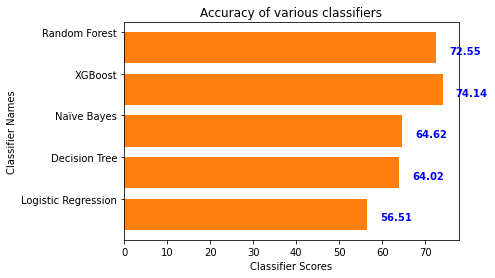

In [18]:
classifier_names = np.array(['Logistic Regression', 'Decision Tree',
                    'Naïve Bayes', 'XGBoost', 'Random Forest'])

classifier_scores = np.array([acc_lr, acc_dtree, 
                              acc_nb, acc_xgb, acc_rfm]).round(2)

# Plotting the bar graph of accuracy for every classifier

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(classifier_scores))  # the x locations for the groups
for i, v in enumerate(classifier_scores):
    ax.text(v + 3, i - .15, str(v), color='blue', fontweight='bold')
ax.barh(ind, classifier_scores, width, color="tab:orange")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(classifier_names, minor=False)
plt.title('Accuracy of various classifiers')
plt.xlabel('Classifier Scores')
plt.ylabel('Classifier Names')   

### 5. Prediction (making predictions with the highest scoring classifier i.e. XGBoost)

In [19]:
predictions = xgb.predict(test_data)

### 6. Submission

In [22]:
submission = pd.DataFrame({'ID': test_data.index,
                    'Is_Lead': predictions})

submission.to_csv(r'C:\Users\HELLO\Favorites\Downloads\Credit Card\submission.csv', index=False)